# Shift Scheduling Automation Model

### Import packages

In [466]:
from pulp import *
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

### Initialize Variables

In [467]:
days = 90
employees = 50
min_resource_count = 10
max_consecutive_days = 6

In [468]:
var_L = pulp.LpVariable.dicts('Leave', (range(days), range(employees)), 0, 1, 'Binary')
var_M = pulp.LpVariable.dicts('Morning', (range(days), range(employees)), 0, 1, 'Binary')
var_N = pulp.LpVariable.dicts('Night', (range(days), range(employees)), 0, 1, 'Binary')

### Objective Function

In [449]:
obj = []
for i in range(days):
    for j in range(employees):
        obj += var_M[i][j] + var_N[i][j]


In [450]:
problem = pulp.LpProblem(name='shift_scheduling',sense= LpMaximize)
problem += obj

### Constraints

#### Constraint 1 - Only 1 shift either morning or night per employee

In [452]:
for i in range(days):
    for j in range(employees):
        const_1 = []
        const_1 += var_L[i][j] + var_M[i][j] + var_N[i][j] 
        problem += const_1 == 1

#### Constraint 2 - Minimum employee per shift constraint

In [454]:

for i in range(days):
    const_2_1 = []
    const_2_2 = [] 
    for j in range(employees):   
        const_2_1 += var_M[i][j]
        const_2_2 += var_N[i][j]
    problem += const_2_1 >= min_resource_count
    problem += const_2_2 >= min_resource_count
        


#### Constraint 3 - Employee needs to be on same shift in consecutive days, people can't work night and then come in for the next morning's shift

In [456]:
for j in range(employees):
    for i in range(days - 1):
        const_3_1 = []
        const_3_1 += var_M[i][j] + var_N[i+1][j]
        problem += const_3_1 <= 1 

for j in range(employees):
    for i in range(days - 1): 
        const_3_2 = []
        const_3_2 += var_N[i][j] + var_M[i+1][j]
        problem += const_3_2 <= 1
    

##### Constraint 4 - Rotating shift atleast once in 2 weeks

In [458]:
# Morning 
for j in range(employees):
    for i in range(0, days - 14, 2):
        const_4_1 = None
        const_4_1 += var_M[i][j] + var_M[i+7][j] + var_M[i+14][j]
        problem += const_4_1 <= 2

# Morning 
for j in range(employees):
    for i in range(0, days - 14, 2):
        const_4_2 = None
        const_4_2 += var_N[i][j] + var_N[i+7][j] + var_N[i+14][j]
        problem += const_4_2 <= 2



##### Constraint 5 - Max consecutive days worked

In [460]:
       
for j in range(employees):
    for i in range(0, days-6):
        const_5 = []
        for w in range(7):
            const_5 += var_M[i+w][j] + var_N[i+w][j]
        problem += const_5 <= max_consecutive_days

### Checking if optimal solution is found and also checking runtime

In [469]:
import time
start = time.time()

if problem.solve() == 1:
    print('Optimal Solution Found')
else:
    print('Optimal Solution Not Available')

end = time.time()
print(end - start)


Optimal Solution Found
1019.8371398448944


### Putting the schedule in a dataframe

In [463]:

variable_name = []
variable_value = []

for v in problem.variables():
    if v.varValue == 1:
        variable_name.append(v.name)
        variable_value.append(v.varValue)
        
df = pd.DataFrame({'variable': variable_name, 'value': variable_value})

# Splitting the variable name

df[['shift','day','employee']] = df['variable'].str.split('_',expand=True)

# Accounting for python 0 indexing

df['day'] = pd.to_numeric(df['day'])+1

df['employee'] = pd.to_numeric(df['employee'])+1


In [464]:
df

,variable,value,shift,day,employee
0,Leave_10_8,1.0,Leave,11,9
1,Leave_11_11,1.0,Leave,12,12
2,Leave_11_14,1.0,Leave,12,15
3,Leave_11_15,1.0,Leave,12,16
4,Leave_11_21,1.0,Leave,12,22
...,...,...,...,...,...
4495,Night_9_48,1.0,Night,10,49
4496,Night_9_49,1.0,Night,10,50
4497,Night_9_5,1.0,Night,10,6
4498,Night_9_6,1.0,Night,10,7


In [465]:
df.to_csv('E:/Arvind/Masters/UC Course Material/BANA 7020 - OPTIMIZATION/Project/schedule.csv')

### Visualizing the schedule

<AxesSubplot:xlabel='day', ylabel='employee'>

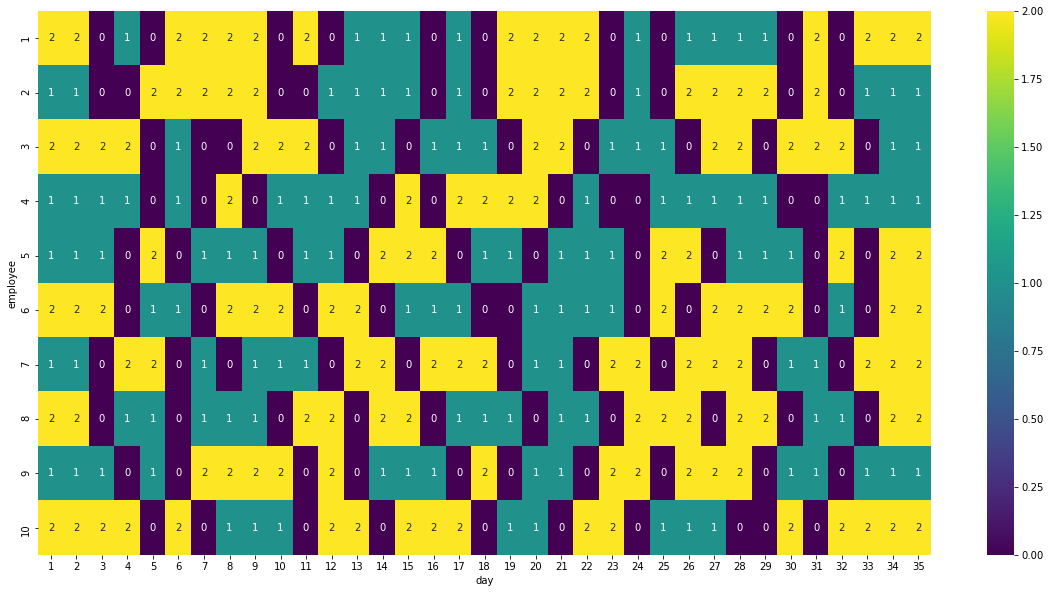

In [440]:

df['shift_encoded'] = pd.factorize(df['shift'])[0]

df_heatmap = df[['day','employee','shift_encoded']].pivot_table(values='shift_encoded',index='employee',columns='day')

plt.figure(figsize = (20,10))

sns.heatmap(df_heatmap, annot=True, fmt="g", cmap='viridis')
